# [NML-25] Notebook 5: Graph Neural Networks

TAs: [Sevda Öğüt](https://people.epfl.ch/sevda.ogut)

## Instructions

**Expected output:**

You will have coding and theoretical questions. Coding exercises shall be solved within the specified space:
```python
# Your solution here ###########################################################
...
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
```
Sometimes we provide variable names, such as `x = ...`; do not change names and stick to hinted typing, as they will be reused later.
Within the solution space, you can declare any other variable or function that you might need, but anything outside these lines shall not be changed, or it will invalidate your answers.

Theoretical questions shall be answered in the following markdown cell. The first line will be
```markdown
**Your answer here:**
...
```

**Solutions:**
* Your code should be self-contained in the `.ipynb` file. The solution to the exercices will be provided in an external `.ipynb` file.

* Try to make your code clean and readable, it is a good training for the project. Provide meaningful variable names and comment where needed.

* You cannot import any other library than we imported, unless explicitly stated.

## Objective

This assignment focuses on Graph Neural Networks.
In the first part, you will load and prepare data using the PyTorch Geometric library, define a GNN, implement train and test functions, and comment on the results.
In the second part, you will define a new GNN and include it in the previous architecture.

Please make sure you install the packages in `requirements.txt` respective to this notebook in your environment. Make sure that your Python version is not greater than 3.11!

In [1]:
# %pip install -r requirements.txt

In [2]:
import torch

Note that wheels are currently not available for M1/M2/M3 macs. Please install the extension packages (pyg_lib and torch_sparse) from source if you have mac. See the [installation documentation](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html) for details!

In [3]:
# %pip install pyg_lib torch_sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html

## Prerequisites

The additional [tutorial](gdl_tutorial.ipynb) provides a broad overview of PyTorch and PyTorch Geometric, showing how to manipulate tensors and train neural networks as well as graph neural networks.

The following resources might help you familiarize with PyTorch and PyTorch geometric.

* [PyTorch: Learn the Basics](https://pytorch.org/tutorials/beginner/basics/intro.html)
* [PyTorch Geometric: Official Tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html#official-examples)


## Section 0: Explore the data

In this section, we will go through the data to get a feeling of its content. We work with the [GitHub dataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.GitHub.html), from the [Multi-scale Attributed Node Embedding](https://arxiv.org/abs/1909.13021) paper. In this dataset, nodes represent developers on GitHub and edges are mutual follower relationships. It contains 37 300 nodes, 578 006 edges, 128-dimensional node features and 2 classes.

This dataset is readily available in PyTorch Geometric, so let's import relevant libraries and then install the dataset!

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch_geometric as pyg
from scipy import sparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torch_geometric.datasets import GitHub
from torchmetrics import Metric
from torchmetrics.classification import Accuracy, BinaryF1Score, Precision, Recall

In [5]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

device = 'cpu'

In [6]:
dataset = GitHub(".")
data = dataset._data

Now, we shall study its content. Node attributes are accessible through the `x` attribute, which is a `torch.Tensor`.

In [7]:
print("Design matrix")
n_nodes, n_feats = data.x.shape
print(f"Num. nodes: {n_nodes}; num features: {n_feats}")

Design matrix
Num. nodes: 37700; num features: 128


We see that we have 37 700 nodes, each with 128 features. The features correspond to an embedding of location, starred repositories, employer, and e-mail address information of each user. Each node comes with a binary label, which indicates whether it corresponds to a web or a machine learning developer.

In [8]:
print("Target vector")
print("First five elements:", data.y[:5])
print("Number of samples:", data.y.shape)
print("Number of nodes in class 1:", data.y.sum().item())

Target vector
First five elements: tensor([0, 0, 1, 0, 1])
Number of samples: torch.Size([37700])
Number of nodes in class 1: 9739


We see that the task is quite imbalanced, as class 1 is underrepresented. To get more meaningful interpretations, we swap classes zero and one.

In [9]:
data.y = 1 - data.y

The edges are contained in the `edge_index` attribute, which is again a tensor. Let's check its shape.

In [10]:
print("Edge index shape:", data.edge_index.shape)

Edge index shape: torch.Size([2, 578006])


Describe the content of the edge index matrix and how it relates to the adjacency matrix.

**Your answer here:**

The shape of this matrix is [2, num_edges], meaning that there is 578006 edges in the graph.

Now, we will create two random binary masks on the nodes: one for training and one for testing. We would like to have 80% of the samples in the training split, so we will uniformly pick nodes with that probability.

We use a masking strategy instead of directly splitting the data because our interpretation of the task is that we have a social network in which the training labels are accessible, while the test nodes, even though available, are unknown. This simplifies the sampling strategy, in particular for network methods, as we do not have to worry about loosing structure.

In [11]:
rng = torch.Generator().manual_seed(452)
train_mask = torch.randn(n_nodes, generator=rng) < 0.8

n_nodes_tr = train_mask.sum().item()
print(f"Training set size: {n_nodes_tr} ({n_nodes_tr / n_nodes:.2%})")
print(f"Test set size: {n_nodes - n_nodes_tr} ({1 - n_nodes_tr / n_nodes:.2%})")
print(
    f"Ratio of class 1 in training: {torch.sum(train_mask * data.y).item() / n_nodes_tr:.2%}"
)

Training set size: 29636 (78.61%)
Test set size: 8064 (21.39%)
Ratio of class 1 in training: 74.12%


Note that a graph with 37 700 nodes yields a 37 700 × 37 700 matrix, which has approximately 1 421 290 000 entries. Suppose that this graph is stored with a **dense** representation with 1 bit per entry, then this would result in ~170 MB of storage space. If 8 bits (1 byte) are used per entry, then this would give us ~1.42 GB. Since PyTorch uses 64-bit floats (8 bytes) per entry, we would get more than 10 GB for this graph. This illustrates that even though many entries may be zero (meaning no edge) in this 37 700 x 37 700 matrix, a dense representation allocates space for all possible node pairs. However, in a **sparse** representation, instead of storing all possible entries, only the existing edges (nonzero entries) are stored, which  can significantly reduce the required space (if you do the math it's ~2.2 MB in this example) 😄

## Section 1: Deep learning on graph data

This part presents a general workflow for deep learning and our recommended libraries: PyTorch and PyTorch Geometric. We will start with classical ML baselines, to get some robust results to which we can compare. Then we will introduce graph features, to see whether they can help in our task. Finally, we will work with deep learning and graph neural networks.

### Question 1.1: Baseline

In this question we define a baseline model with a classical ML method, namely a random forest, to get an idea of what performances we can expect from the following models. This model will only use node features, so it does not leverage at all the graph structure.

**1.1.1** Train a random forest classifier based on the node features. Make sure to use the provided `train_mask` for both the features and the target labels.

In [12]:
data.x

tensor([[ 1.4799, -0.6568, -0.1793,  ..., -0.2258,  2.0619,  0.1963],
        [-0.9020, -0.6568, -0.1793,  ..., -0.2420, -0.4832, -0.2165],
        [-0.3659, -0.6568, -0.1793,  ...,  2.5961,  2.0635, -0.2165],
        ...,
        [ 1.2091, -0.6568, -0.1793,  ..., -0.2274, -0.4849, -0.2165],
        [-0.9020, -0.6551, -0.1793,  ..., -0.2420, -0.4854, -0.2079],
        [-0.9020,  1.5236, -0.1793,  ..., -0.2420, -0.4854, -0.2165]])

In [13]:
# Your solution here ###########################################################

rf_classifier = RandomForestClassifier()

X_tr = data.x[train_mask]
y_tr = data.y[train_mask]

rf_classifier.fit(X_tr, y_tr)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

RandomForestClassifier()

**1.1.2** Predict the labels of the test nodes, then print the `classification_report`.

In [14]:
# Your solution here ###########################################################
X_te = data.x[~train_mask]
y_te = data.y[~train_mask]

predictions = rf_classifier.predict(X_te)

print(classification_report(y_true=y_te, y_pred=predictions))
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

              precision    recall  f1-score   support

           0       0.80      0.63      0.71      2070
           1       0.88      0.95      0.91      5994

    accuracy                           0.87      8064
   macro avg       0.84      0.79      0.81      8064
weighted avg       0.86      0.87      0.86      8064



**1.1.3** Discuss what metric would be the most suitable for our setting.

**Your answer here:**

F1 score

### Question 1.2: Graph baseline - Laplacian eigenmaps

Now, let's implement a second benchmark, this time relying on structural properties. We would like to use eigenmaps of the Laplacian, but if you try to do it you would quickly run out of memory! (Go ahead and try if you wish 😉)

The adjacency matrix is too big to use it in computations, but it would be mainly filled with zeros. We can optimize memory and running time by using a **sparse representation** as discussed above.

**1.2.1** Compute the Laplacian matrix as a [sparse SciPy array][scipy_sparse]. Start by creating a sparse adjacency matrix form the `edge_index`, supposing that all edge weights are 1.

[scipy_sparse]: https://docs.scipy.org/doc/scipy/reference/sparse.html

In [15]:
def compute_laplacian(adjacency: sparse.spmatrix, normalize: str):
    """
    Parameters:
        adjacency (sparse.spmatrix): sparse adjacency matrix
        normalize (str): None, 'sym' or 'rw'

    Returns:
        L (sparse.spmatrix): Laplacian matrix (in sparse format)
    """
    diag = np.array(adjacency.sum(axis=1)).flatten()
    n = adjacency.shape[0]

    # Degree matrix as diagonal sparse matrix
    D = sparse.diags(diag)

    # Combinatorial Laplacian
    L = D - adjacency

    if normalize is None:
        return L

    # Avoid division by zero
    diag[diag == 0] = 1e-12

    if normalize == "sym":
        # D^(-1/2) A D^(-1/2)
        deg_inv_sqrt = 1.0 / np.sqrt(diag)
        D_inv_sqrt = sparse.diags(deg_inv_sqrt)
        L_norm = sparse.eye(n) - D_inv_sqrt @ adjacency @ D_inv_sqrt
        return L_norm

    elif normalize == "rw":
        # D^(-1) A
        deg_inv = 1.0 / diag
        D_inv = sparse.diags(deg_inv)
        L_norm = sparse.eye(n) - D_inv @ adjacency
        return L_norm

    else:
        raise ValueError(f"Unknown normalization: {normalize}")

In [18]:
# Your solution here ###########################################################

num_nodes = data.x.shape[0]
num_edges = data.edge_index.shape[1]
print(f"Num. nodes: {num_nodes}; num edges: {num_edges}")
adjacency = sparse.coo_matrix(
    (np.ones(data.edge_index.shape[1]), (data.edge_index[0], data.edge_index[1])),
    shape=(num_nodes, num_nodes)
)

laplacian = compute_laplacian(adjacency, normalize='sym')
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Num. nodes: 37700; num edges: 578006


**1.2.2** Use SciPy sparse linear algebra capabilities to compute the first 5 nontrivial eigenvectors of the Laplacian.

*Note: If this takes too long, you can change the condition to False after completing Question 1.2 to iterate more quickly over the following ones.*

In [19]:
from scipy.sparse.linalg import eigsh
# Your solution here ###########################################################

if True:  # Change to True to run cell

    eigvals, eigvecs = eigsh(laplacian, k=6, which="SM")
    eigvecs = eigvecs[:, 1:]

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

else:
    eigvecs = np.random.rand(n_nodes, 5)

**1.2.3** Train and test a new random forest classifier using the eigenvector representation as features.

In [20]:
# Your solution here ###########################################################
rf_classifier = RandomForestClassifier()

X_tr = eigvecs[train_mask]
y_tr = data.y[train_mask]

rf_classifier.fit(X_tr, y_tr)

X_te = eigvecs[~train_mask]
y_te = data.y[~train_mask]

predictions = rf_classifier.predict(X_te)

print(classification_report(y_true=y_te, y_pred=predictions))
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

              precision    recall  f1-score   support

           0       0.77      0.62      0.69      2070
           1       0.88      0.94      0.91      5994

    accuracy                           0.85      8064
   macro avg       0.82      0.78      0.80      8064
weighted avg       0.85      0.85      0.85      8064



**1.2.4** Now, combine the two sets of features, i.e. the given programmers features and the Laplacian eigenmaps, into a single design matrix, then train and test another random forest classifier.

In [21]:
# Your solution here ###########################################################
X_tr = torch.concat([data.x[train_mask], torch.tensor(eigvecs[train_mask])], dim=1)
y_tr = data.y[train_mask]
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_tr, y_tr)
X_te = torch.concat([data.x[~train_mask], torch.tensor(eigvecs[~train_mask])], dim=1)
y_te = data.y[~train_mask]
predictions = rf_classifier.predict(X_te)
print(classification_report(y_true=y_te, y_pred=predictions))

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

              precision    recall  f1-score   support

           0       0.82      0.66      0.73      2070
           1       0.89      0.95      0.92      5994

    accuracy                           0.87      8064
   macro avg       0.85      0.80      0.82      8064
weighted avg       0.87      0.87      0.87      8064



**1.2.5** Comment on the results and describe which model you expect to perform the best on unseen data.

**Your answer here:**
The combined model performs better.

### Question 1.3: Neural network baseline - MLP

In this question, we move from classical ML to deep learning and, again, we start from a simple model to get a viable benchmark.

**1.3.1** Create two `DataLoaders`, for the training and test data respectively, by using the `TensorDataset` class. Use the predefined batch size and shuffle training data.

References:
- [Datasets and DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
- [PyTorch data utility](https://pytorch.org/docs/stable/data.html)

In [22]:
batch_size = 128

# Your solution here ###########################################################

loader_train = DataLoader(TensorDataset(data.x[train_mask], data.y[train_mask]),
                          batch_size=batch_size,
                          shuffle=True)

loader_test = DataLoader(TensorDataset(data.x[~train_mask], data.y[~train_mask]),
                          batch_size=batch_size,
                          shuffle=False)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.3.2** Define a [module][nn_module] for a two-layer perceptron with the ReLU activation function. The hidden dimension will be a parameter of the constructor function.
This neural network will take as input a design matrix and predict the "logits" of class 1.

[nn_module]: https://pytorch.org/docs/stable/generated/torch.nn.Module.html

In [23]:
class MLP(nn.Module):
    # Your solution here #######################################################
    def __init__(self, in_features: int, hidden_features: int):
        super().__init__()
        self.linear1 = nn.Linear(in_features=in_features, out_features=hidden_features)
        self.linear2 = nn.Linear(in_features=hidden_features, out_features=1)

    def forward(self,x):
        x = self.linear1(x).relu()
        logits = self.linear2(x)

        return logits

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.3.3** Define a function to perform one training step for a given NN, taking as argument a batch of data `x` with target `y`, an optimizer, and a loss function. The function should return the loss value, as a float.

In [24]:
def train_nn_step(
    optimizer: optim.Optimizer,
    loss_fn: nn.Module,
    model: nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
) -> float:
    model.train()  # Used to ensure that relevant blocks are in training mode

    # Your solution here #######################################################
    optimizer.zero_grad()

    out = model(x).squeeze()
    loss = loss_fn(out,y)
    loss.backward()
    optimizer.step()

    return loss
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.3.4** Write an evaluation function that takes as input a PyTorch Module, a data loader, and a [TorchMetrics function][torchmetrics] and returns the cumulative metric over all batches.

[TorchMetrics][torchmetrics] is a convenient package that implements metrics that work with PyTorch Tensors, and also with batched data.

[torchmetrics]: https://lightning.ai/docs/torchmetrics/stable/pages/quickstart.html

In [25]:
def eval_nn(model: nn.Module, loader: DataLoader, metric_fn: Metric) -> float:
    model.eval()  # Used to ensure that relevant block are in evaluation model

    # Your solution here #######################################################
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        preds = model(x).sigmoid().squeeze()

        _ = metric_fn(preds, y)

    return metric_fn.compute().item()
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.3.5** Create an instance of the previously defined MLP, a relevant [loss function][torch_loss] for our classification task, and an optimizer.
When needed, as for the MLP hidden dimension and optimizer learning rate, select parameters that provide good results for the task. You might need some trial-and-error, so keep track of you results as you will be asked to comment on those hyperparameters.

Make sure to send everything to the correct device at initialization, as moving information from the CPU to the GPU is time-consuming.

[torch_loss]: https://pytorch.org/docs/stable/nn.html#loss-functions
[torch_optim]: https://pytorch.org/docs/stable/optim.html

In [26]:
print(f"Using {device} device")

# Your solution here ###########################################################

mlp = MLP(data.x.shape[1], hidden_features=64).to(device)

loss_fn = nn.BCEWithLogitsLoss().to(device)

optimizer = optim.Adam(mlp.parameters(), lr=0.005)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using cpu device


**1.3.6** Perform 10 epochs of training. During each epoch, you should perform training steps iterating over the whole dataset. Gather the losses of each batch, and plot the evolution of the training loss at the end.

Epoch: 100%|██████████| 15/15 [00:01<00:00,  8.73it/s]


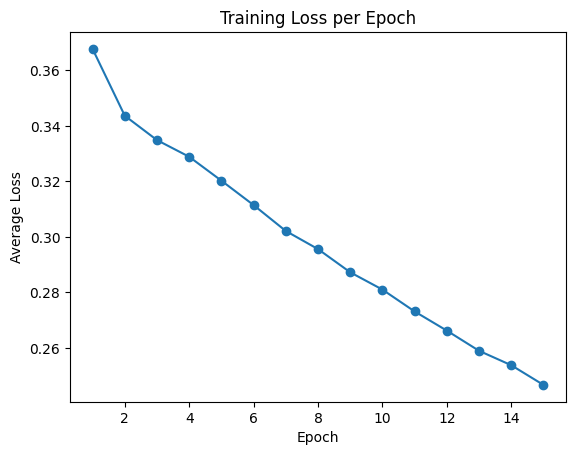

In [27]:
n_epochs = 15

# Your solution here ###########################################################
from tqdm import tqdm

losses = []

for epoch in tqdm(range(n_epochs), desc='Epoch'):
    epoch_losses = []
    for x,y in loader_train:
        loss = train_nn_step(optimizer, loss_fn, mlp, x.to(device), y.to(device).float())
        epoch_losses.append(loss)
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(avg_loss.item())

plt.plot(range(1, n_epochs + 1), losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss per Epoch")

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

**1.3.7** Evaluate the trained model on both the training and test data, using the most relevant metric from those already imported from TorchMetrics.

In [28]:
# Your solution here ###########################################################

metric_fn = BinaryF1Score().to(device)

metric_tr = eval_nn(mlp, loader_train, metric_fn)
metric_te = eval_nn(mlp, loader_test, metric_fn)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

Training metric: 0.936
Test metric:     0.915


**1.3.8** Try different hyperparameters' combinations, in particular for the hidden dimension of the MLP and the learning rate of the optimizer. Then discuss the obtained results and the learning curves.

**Your answer here:**
...

### Question 1.4: Graph Neural Networks

We will now shift from the standard deep learning paradigm to Graph Neural Networks, to leverage the additional structure of our data.

We already imported [PyTorch Geometric][torch_geometric] as `pyg`, so you can access its submodules as `pyg.nn`, `pyg.data`, and so on.

[torch_geometric]: https://pytorch-geometric.readthedocs.io/en/latest/index.html

**1.4.1** Let's start by defining our first GNN. Again, it will be a subclass of the PyTorch `Module`, but this time it will take into account the `edge_index` in its `forward method`. Use two [GCN layers][gcn] to go from input features, here called *channels*, to a hidden dimension defined in the constructor, then to logit readout. Use ReLU activations.

This GNN will map node vectors to node logits.

[gcn]: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html

In [38]:
class GCN(nn.Module):
    # Your solution here #######################################################
    def __init__(self, in_channels: int, hidden_channels: int):
        super().__init__()
        self.conv1 = pyg.nn.GCNConv(in_channels=in_channels, out_channels=hidden_channels)
        self.conv2 = pyg.nn.GCNConv(in_channels=hidden_channels, out_channels=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        logits = self.conv2(x, edge_index)

        return logits
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.4.2** Perform `n_epochs` of training of a GCN model with 64 hidden channels, using full training data as a batch. Make sure to only use training data in the loss computation by using the `train_mask`. Track the loss value at each step and plot it. Finally, evaluate the model on train and test, using the `metric_fn` from before.

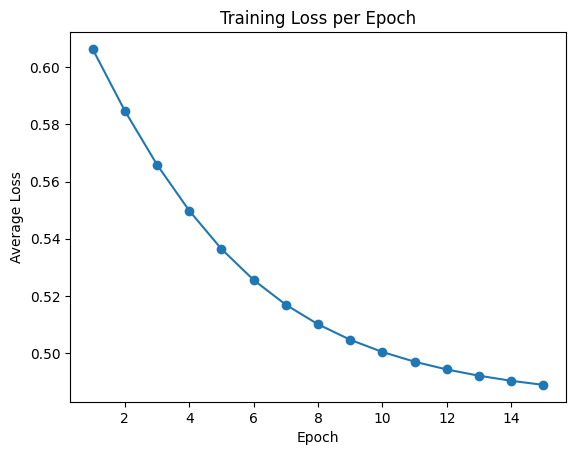

Training metric: 0.909
Test metric:     0.912


In [39]:
# Your solution here ###########################################################

def evaluate_gnn(model, data, train_mask, metric_fn):
    data = data.to(device)
    y_pred = model(data).squeeze()

    metric_fn.reset()
    metric_tr = metric_fn(y_pred[train_mask], data.y[train_mask])

    metric_fn.reset()
    metric_te = metric_fn(y_pred[~train_mask], data.y[~train_mask])

    return metric_tr, metric_te


def train_gnn_full(model, data, loss_fn, optimizer, n_epochs):
    loss_list = []

    data = data.to(device)

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        y_pred = model(data).sigmoid().squeeze()
        loss = loss_fn(y_pred[train_mask], data.y[train_mask].float())
        loss.backward()

        optimizer.step()
        loss_list.append(loss.item())

    return loss_list

gcn = GCN(in_channels=data.x.shape[1], hidden_channels=64).to(device)
optimizer = optim.Adam(gcn.parameters(), lr=0.01)
loss_list = train_gnn_full(gcn, data, loss_fn, optimizer, n_epochs)

metric_tr, metric_te = evaluate_gnn(gcn, data, train_mask, metric_fn)
plt.plot(range(1, n_epochs + 1), loss_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss per Epoch")
plt.show()

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

**1.4.3** Hopefully, we got already some good results, but we would like to test whether stochastic optimization might be better. Batching graph data requires a particular approach, since on top of the design matrix with node features we have to account for edge information. In our setting, we have a single graph with many nodes, and a node level task. A batching strategy consists in sampling nodes with their neighbors, then working with this smaller graphs in a batched way.

Define one [NeighborLoader][neighborloader] for the training data, which will gather neighbors for as many *iterations* as layers in your GCN. Check [mini batches](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html#mini-batches) if needed.

[neighborloader]: https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader

In [40]:
batch_size = 1024

# Your solution here ###########################################################
from torch_geometric.loader import NeighborLoader
loader_graph_train = NeighborLoader(data, 
                                    num_neighbors=[-1]*2,
                                    batch_size=batch_size,
                                    input_nodes=train_mask)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.4.4** Use the previously defined `train_nn_step` to train a newly initialized GCN with the new loader. Again plot the loss evolution and evaluate the trained model on train and test data.

Epoch 1/15: Average Loss = 0.8012
Epoch 2/15: Average Loss = 0.4388
Epoch 3/15: Average Loss = 0.3915
Epoch 4/15: Average Loss = 0.3768
Epoch 5/15: Average Loss = 0.3685
Epoch 6/15: Average Loss = 0.3625
Epoch 7/15: Average Loss = 0.3578
Epoch 8/15: Average Loss = 0.3539
Epoch 9/15: Average Loss = 0.3505
Epoch 10/15: Average Loss = 0.3474
Epoch 11/15: Average Loss = 0.3447
Epoch 12/15: Average Loss = 0.3422
Epoch 13/15: Average Loss = 0.3398
Epoch 14/15: Average Loss = 0.3375
Epoch 15/15: Average Loss = 0.3354


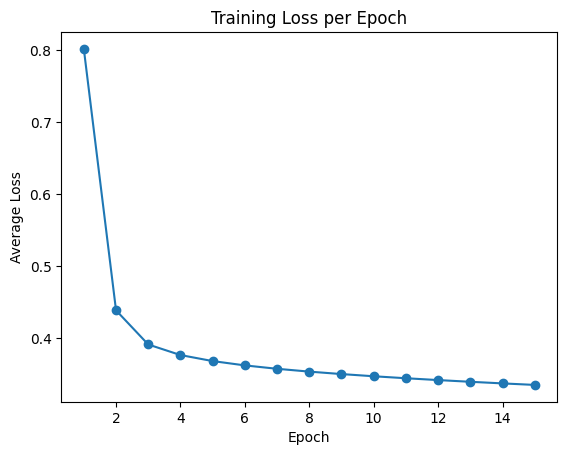

In [41]:
# Your solution here ###########################################################

def train_gnn_batch(model, loader, loss_fn, optimizer, n_epochs):
    epoch_loss_list = []
    for epoch in range(n_epochs):
        batch_losses = []
        for batch in loader:
            loss = train_nn_step(
                optimizer, loss_fn, model, batch.to(device), batch.y.to(device).float()
            )
            batch_losses.append(loss)

        avg_loss = sum(batch_losses) / len(batch_losses)
        epoch_loss_list.append(avg_loss.item())
        print(f"Epoch {epoch+1}/{n_epochs}: Average Loss = {avg_loss:.4f}")
    return epoch_loss_list

gcn = GCN(data.x.shape[1], hidden_channels=64).to(device)
optimizer = optim.Adam(gcn.parameters(), lr=0.001)

loss_list = train_gnn_batch(gcn, loader_graph_train, loss_fn, optimizer, n_epochs)

plt.plot(range(1, n_epochs + 1), loss_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss per Epoch")

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.show()

**1.4.5** Predict the label probabilities of each node and evaluate.

In [42]:
# Your solution here ###########################################################

metric_tr, metric_te = evaluate_gnn(gcn, data, train_mask, metric_fn)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

Training metric: 0.911
Test metric:     0.915


**1.4.6** Define a new GNN architecture using [graph attention layers][gat].

[gat]: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATv2Conv.html#torch_geometric.nn.conv.GATv2Conv

In [43]:
class GAT(nn.Module):
    # Your solution here #######################################################
    def __init__(self, in_channels: int, hidden_channels: int):
        super().__init__()
        self.conv1 = pyg.nn.GATv2Conv(in_channels=in_channels,
                                      out_channels=hidden_channels)
        self.conv2 = pyg.nn.GATv2Conv(in_channels=hidden_channels,
                                      out_channels=1)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x,edge_index).relu()
        logits = self.conv2(x, edge_index)
        return logits
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**1.4.7** Train and evaluate the GAT model with both methods.

FULL TRAINING


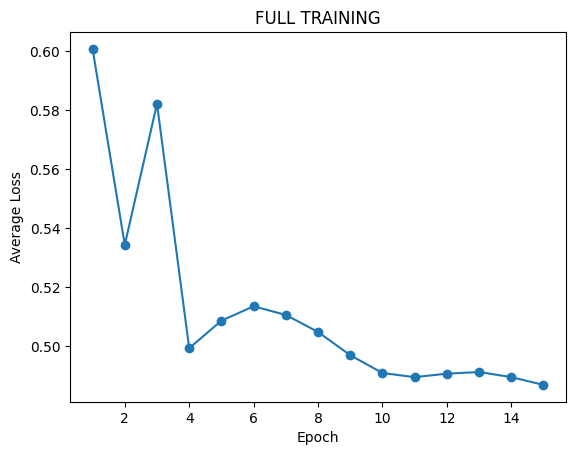

Training metric: 0.901
Test metric:     0.899
BATCH TRAINING
Epoch 1/15: Average Loss = 0.3752
Epoch 2/15: Average Loss = 0.3117
Epoch 3/15: Average Loss = 0.2899
Epoch 4/15: Average Loss = 0.2682
Epoch 5/15: Average Loss = 0.2491
Epoch 6/15: Average Loss = 0.2333
Epoch 7/15: Average Loss = 0.2205
Epoch 8/15: Average Loss = 0.2093
Epoch 9/15: Average Loss = 0.1999
Epoch 10/15: Average Loss = 0.1917
Epoch 11/15: Average Loss = 0.1851
Epoch 12/15: Average Loss = 0.1794
Epoch 13/15: Average Loss = 0.1748
Epoch 14/15: Average Loss = 0.1708
Epoch 15/15: Average Loss = 0.1668


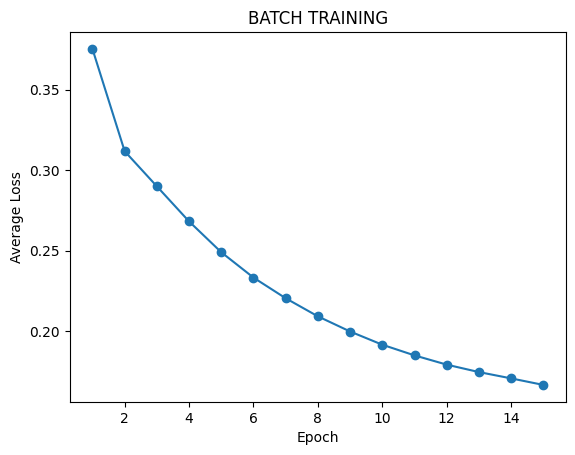

Training metric: 0.943
Test metric:     0.937


In [44]:
print("FULL TRAINING")

# Your solution here ###########################################################

gat = GAT(data.x.shape[1], hidden_channels=64).to(device)
optimizer = optim.Adam(gat.parameters(), lr=0.05)

loss_list = train_gnn_full(gat, data, loss_fn, optimizer, n_epochs)

plt.plot(range(1, n_epochs + 1), loss_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")

metric_tr, metric_te = evaluate_gnn(gat, data, train_mask, metric_fn)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.title("FULL TRAINING")
plt.show()

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

print("BATCH TRAINING")

# Your solution here ###########################################################

gat = GAT(data.x.shape[1], hidden_channels=64).to(device)
optimizer = optim.Adam(gat.parameters(), lr=0.01)

loss_list = train_gnn_batch(gat, loader_graph_train, loss_fn, optimizer, n_epochs)

plt.plot(range(1, n_epochs + 1), loss_list, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")

metric_tr, metric_te = evaluate_gnn(gat, data, train_mask, metric_fn)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.title("BATCH TRAINING")
plt.show()

print(f"Training metric: {metric_tr:.3f}")
print(f"Test metric:     {metric_te:.3f}")

## Section 2: Learning graphs

Graph attention layers are quite interesting because they dynamically weight each neighbor based on both local and incoming information from a node. This mechanism is conceptually similar to learning an entirely new graph structure on top of the existing one.

In this part, we design a block that, from node embeddings, will produce a new graph. The idea is similar to the one in the paper [Discrete Graph Structure Learning for Forecasting Multiple Time Series](https://openreview.net/forum?id=WEHSlH5mOk), which is illustrated in the following figure.

![Graph Learning Module](graph_learning_module.png)

As we can see from the schema, we have three main components:
1. **Feature extractor**: Maps each node to a new, synthesized representation.
2. **Link predictor**: for each pair of node representations, predicts the probability that an edge links them. We gather probabilities in a *structure matrix* $\theta$.
3. **Sampling**: Samples one, or multiple, discrete graphs from the structure matrix.

In the following questions, we will break down these components.

### Question 2.1: Sampling

Sampling is the most intriguing part of our module, as it maps, randomly, continuous probabilities to discrete edges. Ideally, we would like to sample each edge with a probability $\theta$, following a Bernoulli distribution, but this would be hard to backpropagate through.

What we do instead is known as the **Gumbel Trick**.
We sample edges using a [Gumbel][gumbel] reparameterization, which allows differentiating for $\theta$ through it. With $g_{ij}^1, g_{ij}^2 \sim \operatorname{Gumbel}(0,1)$ for all $i,j$, and $s$ a temperature parameter,
$$
A_{ij} = \operatorname{sigmoid}\left(
  \frac{
    \log\left( \frac{\theta_{ij}}{1 - \theta_{ij}} \right)
    + g_{ij}^1 - g_{ij}^2
  }{s}
\right)
.
$$
By letting the temperature go to zero, we can get closer and closer to a Bernoulli distribution.

[gumbel]: https://en.wikipedia.org/wiki/Gumbel_distribution

**2.1.1** Define a function to sample a matrix of Gumbel variables of given shape, knowing that, for $p$ sampled uniformly in (0,1), then $Q(p) \sim \operatorname{Gumbel}(\mu,\beta)$
$$
  Q(p)=\mu-\beta \ln (-\ln (p))
  .
$$

In [46]:
def sample_gumbel(shape, mu=0, beta=1):
    # Your solution here #######################################################
    Q = torch.rand(shape)

    Q = mu - beta * torch.log(-torch.log(Q))

    return Q

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


print("Testing sample_gumbel")
print(sample_gumbel((2, 3), 0, 1))

Testing sample_gumbel
tensor([[ 0.4407,  1.4900, -0.2154],
        [-0.8659,  0.9536, -1.0923]])


**2.1.2** Note that $log(\frac{\theta}{1 - \theta})$ is the sigmoid function, so we can work with unnormalized edge logits instead of probabilities. Define a function to sample an adjacency matrix $A$ from edge logits using the Gumbel Trick.

In [51]:
def sample_gumbel_trick(logits, temperature, mu=0, beta=1):
    # Your solution here #######################################################
    g1 = sample_gumbel(logits.shape, mu, beta)
    g2 = sample_gumbel(logits.shape, mu, beta)

    return torch.sigmoid((logits+g1+g2) / temperature)
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


print("Testing sample_gumbel_trick")
print(sample_gumbel_trick(torch.tensor([1000, 0, 0, -10]), temperature=10))
print(sample_gumbel_trick(torch.tensor([1000, 0, 0, -10]), temperature=1))
print(sample_gumbel_trick(torch.tensor([1000, 0, 0, -10]), temperature=1e-2))

Testing sample_gumbel_trick
tensor([1.0000, 0.5149, 0.4715, 0.3648])
tensor([1.0000e+00, 6.6647e-01, 4.7996e-01, 5.6222e-05])
tensor([1., 1., 1., 0.])


### Question 2.2: Link predictor

GNNs are all about node embeddings, which by now we should know how to deal with. The missing component is therefore the **link predictor**. Naively, we could iterate through all pairs of nodes and apply a predictor layer, but it would be highly inefficient. To leverage tensor manipulation, let's start by gathering paired node representations in a matrix, so that we can predict probabilities in parallel.

**2.2.1**  Define a function that takes as input a tensor of node embeddings, and returns a tensor that concatenates embeddings pairwise. Use [triu_indices][triu_indices] to have pairs appearing only once and avoid self loops, and return the indices along with the embeddings.

[triu_indices]: https://pytorch.org/docs/stable/generated/torch.triu_indices.html

In [71]:
def pair_embeddings(x) -> (torch.Tensor, torch.Tensor):
    # Your solution here ###########################################################
    N = x.shape[-2]
    # indices returns a tuple with row and cols indices of 
    # of the upper triangle matrix of shape NxN
    indices = torch.triu_indices(row=N, col=N, offset=1)

    # x[..., indices[0], :] returns the elements of the -1 column
    return torch.cat([x[..., indices[0], :], x[..., indices[1], :]], dim=-1), indices
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


print("Testing pair_embeddings")
print(pair_embeddings(torch.tensor([[1.0], [2.0], [3.0]]))[0])
print(pair_embeddings(torch.tensor([[[1.0], [2.0], [3.0]], [[4.0], [5.0], [6.0]]]))[0])

Testing pair_embeddings
tensor([[1., 2.],
        [1., 3.],
        [2., 3.]])
tensor([[[1., 2.],
         [1., 3.],
         [2., 3.]],

        [[4., 5.],
         [4., 6.],
         [5., 6.]]])


**2.2.2** Define a PyTorch module that takes as input node embeddings, compute link probabilities with a two-layer perceptron on paired embeddings, then samples edges with the Gumbel trick. The output of the forward method will be a PyTorch Geometric [EdgeIndex][edge_index] of tensors representing indices and weights corresponding to positively sampled edges. You might need a `eps` threshold to avoid numerical errors.

[edge_index]: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.EdgeIndex.html

In [77]:
class MLPGraphLearn(nn.Module):
    # Your solution here ###########################################################
    def __init__(
        self, in_features: int, hidden_features: int, temperature: float, eps=1e-10
    ):
        super().__init__()

        self.link_predictor = nn.Sequential(
            nn.Linear(
                in_features=2 * in_features,
                out_features=hidden_features,
            ),
            nn.ReLU(),
            nn.Linear(
                in_features=hidden_features,
                out_features=1,
                bias=False,
            ),
        )

        self.temperature = temperature
        self.eps = eps

    def forward(self, x):
        n_nodes = x.shape[-2]
        x, triu = pair_embeddings(x)

        logits = self.link_predictor(x)

        weights = sample_gumbel_trick(logits, self.temperature).squeeze()

        edge_index = torch.cat([triu, triu.flip(-1)], dim=-1)
        weights = torch.cat([weights, weights])

        return pyg.EdgeIndex(
            edge_index,
            sparse_size=(n_nodes, n_nodes),
            sort_order="row",
            is_undirected=True,
        )[:, weights > self.eps]

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


print("Testing MLPGraphLearn")
mlp_gl = MLPGraphLearn(2, 5, 0.01)
mlp_gl(torch.tensor([[[1.0, 2.0], [0.5, 7.1], [-0.1, 0.3]]]))

Testing MLPGraphLearn


EdgeIndex([[0, 0, 1, 1, 0, 0],
           [1, 2, 2, 2, 2, 1]], sparse_size=(3, 3), nnz=6, sort_order=row)

### Question 2.3: Classifiers

Let's introduce our graph learning block into some classifiers.


**2.3.1** Define a classifier that first produces node embeddings with a linear layer with ReLU activation, which it feeds to the previously defined GL module, then it performs two graph convolutions on the original node features using the learned graph.

In [78]:
class MLPGLClassifier(nn.Module):
    # Your solution here #######################################################
    def __init__(
        self,
        in_features: int,
        gl_node_features_in: int = 64,
        gl_node_features_hidden: int = 32,
        gcn_hidden: int = 64,
    ):
        super().__init__()
        self.feat_extractor = nn.Linear(
            in_features=in_features,
            out_features=gl_node_features_in,
        )
        self.graph_learn = MLPGraphLearn(
            in_features=gl_node_features_in,
            hidden_features=gl_node_features_hidden,
            temperature=1,
        )

        self.conv1 = pyg.nn.GCNConv(in_channels=in_features, out_channels=gcn_hidden)
        self.conv2 = pyg.nn.GCNConv(in_channels=gcn_hidden, out_channels=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        edge_index = self.graph_learn(self.feat_extractor(x).relu())

        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**2.3.2** Unfortunately, training and evaluating the `MLPGLClassifier` might take too long. Let's just test whether it works: instantiate the classifier and compute the graph embedding.

In [79]:
# Your solution here ###########################################################
gl_classifier = MLPGLClassifier(data.x.shape[1]).to(device)
gl_classifier(data)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

: 